<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Utilities-(some-code-to-be-written-in-this-section!)" data-toc-modified-id="Utilities-(some-code-to-be-written-in-this-section!)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities (some code to be written in this section!)</a></span></li><li><span><a href="#Wireframes:-Transforming-and-Drawing" data-toc-modified-id="Wireframes:-Transforming-and-Drawing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Wireframes: Transforming and Drawing</a></span></li><li><span><a href="#The-Pinhole-Camera" data-toc-modified-id="The-Pinhole-Camera-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The Pinhole Camera</a></span></li><li><span><a href="#Camera-Calibration" data-toc-modified-id="Camera-Calibration-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Camera Calibration</a></span></li><li><span><a href="#Augmented-Reality" data-toc-modified-id="Augmented-Reality-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Augmented Reality</a></span><ul class="toc-item"><li><span><a href="#(Bonus)-Animation" data-toc-modified-id="(Bonus)-Animation-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>(Bonus) Animation</a></span></li></ul></li><li><span><a href="#From-2D-to-3D" data-toc-modified-id="From-2D-to-3D-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>From 2D to 3D</a></span><ul class="toc-item"><li><span><a href="#(BONUS)-The-Big-Box" data-toc-modified-id="(BONUS)-The-Big-Box-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>(BONUS) The Big Box</a></span></li></ul></li></ul></div>

# CV-LabExercise: The Pinhole Camera

## 1. Initialization

In [2]:
import numpy as np
from scipy.linalg import inv
import matplotlib.pyplot as plt
import wget
import cv2
from matplotlib.patches import ConnectionPatch
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.linalg import svd
import scipy.spatial.distance

Hidden in this cell are some $\LaTeX$ macros
$\renewcommand{\v}[1]{\mathbf #1}$
$\newcommand{\hv}[1]{\widetilde{\mathbf #1}}$
$\newcommand{\setR}{\mathbb R}$
$\newcommand{\T}{^\top}$
$\newcommand{\inv}{^{-1}}$
$\newcommand{\pfrac}[2]{\frac{\partial #1}{\partial #2}}$

## 2. Utilities

In [3]:
def draw_keypoints(kps, nkps=None, ax=None, marker='x', 
                   marker_size=10, scale_and_orientation=True):
    if ax is None:
        ax = plt.gca()
    if nkps is None:
        nkps = len(kps)
    xs = [kp.pt[0] for kp in kps]
    ys = [kp.pt[1] for kp in kps]
    ax.scatter(xs, ys, marker=marker)
    if scale_and_orientation:
        for kp in kps[:nkps]:
            x, y = kp.pt
            r = kp.size / 2
            angle = kp.angle/2/np.pi
            ax.add_artist(plt.Circle((kp.pt), kp.size/2, 
                                     color='green', fill=False))
            ax.add_artist(plt.Arrow(x, y, r*np.cos(angle), 
                                    r*np.sin(angle), color='red'))
            


def draw_matches(f1, kps1, f2, kps2, matches, 
                 horizontal=True, figsize=(15,15)):
    if horizontal:
        fig, axs = plt.subplots(1,2, figsize=figsize)
    else:
        fig, axs = plt.subplots(2,1, figsize=figsize)
    
    axs[0].imshow(f1)
    axs[1].imshow(f2)
    
    # get the indexes of the matches
    idx1 = [m.queryIdx for m in matches]
    idx2 = [m.trainIdx for m in matches]
    
    xs1 = [kps1[i].pt[0] for i in idx1]
    ys1 = [kps1[i].pt[1] for i in idx1]
    xs2 = [kps2[i].pt[0] for i in idx2]
    ys2 = [kps2[i].pt[1] for i in idx2]
    
    
    for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color='g')
        axs[1].add_artist(con)            


In [4]:
def imshow_row(imttllist, axs=False):
    n = len(imttllist)
    for i, imttl in enumerate(imttllist):
        if imttl is None:
            continue
        im, ttl = imttl
        plt.subplot(1,n,i+1)
        plt.imshow(im, cmap='gray')
        if not axs:
            plt.axis('off')
        plt.title(ttl)

We will also find some use for the ``e2h`` and ``h2e`` functions. We give them to you here.

In [5]:
def e2h(x):
    if len(x.shape) == 1:
        return np.hstack((x, [1]))
    return np.vstack((x, np.ones(x.shape[1])))
    
def h2e(tx):
    return tx[:-1]/tx[-1]

## 3. Wireframes: Transforming and Drawing

In this lab exercise we will often find the need to define, transform and draw wireframes.

We will define a wireframe as a collection of vertices (points) in 2D or 3D and a collection of edges, each edge linking two of the vertices. The vertices are represented with an array of shape (n,d) (with d the dimension, i.e. 2 or 3). The edges are encoded in an array of shape (m,2) where each row is a pair of integers, say (i, j) linking vertices[i] with vertices[j]. As a simple example: the unit square in 2D:

In [6]:
unit_square = (np.array([[0, 0], [1, 0], [1, 1], [0, 1]]),
               np.array([[0, 1], [1, 2], [2, 3], [3, 0]]))

and the unit cube in 3D:

In [7]:
unit_cube = (np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                       [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]]),
             np.array([[0, 1], [1, 2], [2, 3], [3, 0],
                       [4, 5], [5, 6], [6, 7], [7, 4],
                       [0, 4], [1, 5], [2, 6], [3, 7]]))

and a function to make a drawing of it:

In [8]:
def draw_wireframe(ax, wf, colors='red', lw=2, adapt=True):
    """draw a 2D or 3D wireframe. 
    The vertices argument is a (n,2(3)) shaped array where
    each row is a (x,y (,z)) coordinate pair of a vertex and 
    edges is (m,2) array where each row is a tuple (i, j) 
    indicating that vertex[i] is connected with 
    vertex[j] with a straight line"""
    vertices, edges = wf
    segments = np.array([(vertices[i], vertices[j]) for i, j in edges])
    
    twoD = vertices.shape[1] == 2
    if twoD:
        lines = LineCollection(segments, colors=colors)
        ax.add_artist(lines)
        
        if adapt:
            # now adjust the xlim and ylim 
            # to incorporate the added wireframe
            # (seems mpl doesn't do that automatically)
            # we take the bounding box of the set limits and
            # the new wireframe limits
            vxmn, vymn = np.min(vertices, axis=0)
            vxmx, vymx = np.max(vertices, axis=0)
                    
            axmn, axmx = ax.get_xlim()
            aymn, aymx = ax.get_ylim()
                        
            if aymn > aymx:
                # true when an image is shown
                yaxreversed = True
                aymn, aymx = aymx, aymn 
            else:
                yaxreversed = False
            
            axmn = np.minimum(vxmn, axmn)
            axmx = np.maximum(vxmx, axmx)
            ax.set_xlim(axmn, axmx)
        
            aymn = np.minimum(vymn, aymn)
            aymx = np.maximum(vymx, aymx)
                        
            if yaxreversed:
                ax.set_ylim(aymx, aymn)
            else:
                ax.set_ylim(aymn, aymx)
        
    else:
        lines = Line3DCollection(segments, colors=colors)
        ax.add_collection3d(lines)
        
        if adapt:
            # now adjust the xlim, ylim and zlim
            # to incorporate the added wireframe
            # (seems mpl doesn't do that automatically)
            # we take the bounding box of the set limits and
            # the new wireframe limits
            vxmn, vymn, vzmn = np.min(vertices, axis=0)
            vxmx, vymx, vzmx = np.max(vertices, axis=0)
        
            axmn, axmx = ax.get_xlim()
            aymn, aymx = ax.get_ylim()
            azmn, azmx = ax.get_zlim()
            
            axmn = np.minimum(vxmn, axmn)
            axmx = np.maximum(vxmx, axmx)
            
            ax.set_xlim(axmn, axmx)
        
            aymn = np.minimum(vymn, aymn)
            aymx = np.maximum(vymx, aymx)
            
            ax.set_ylim(aymn, aymx)
        
            azmn = np.minimum(vzmn, azmn)
            azmx = np.maximum(vzmx, azmx)
            
            ax.set_zlim(azmn, azmx)
        
            ## Note: there should be a way to do the axis limits settings
            ## independent of the dimension...
    return lines

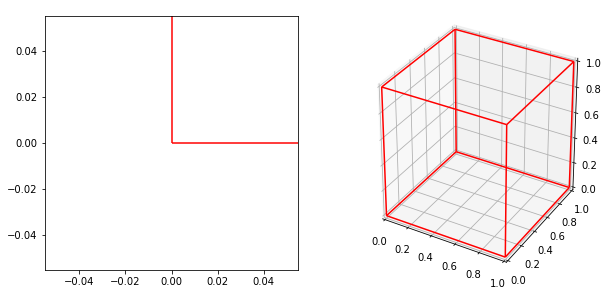

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
draw_wireframe(ax, unit_square)
plt.axis('scaled');
ax = fig.add_subplot(122, projection='3d')
draw_wireframe(ax, unit_cube);

Unfortunately it is not possible to set the aspect ratio of 3D axes in Matplotlib (only the aspect ratio of the entire figure influences the aspect ratio of the plot).

In the lecture Leo shows a piece of Matlab code in which wireframes are used to illustrate the working of a pinhole camera (we do a bit of that in the next section). In that lecture he used a function to construct a 3D rotation using a rotation vector, the vector direction being the axis of rotation and the vector length indicating the angle of rotation.

That can be done in Python too...

In [10]:
from scipy.spatial.transform import Rotation as R
r = R.from_rotvec(np.pi/2*np.array([1,1,1])/np.sqrt(3))

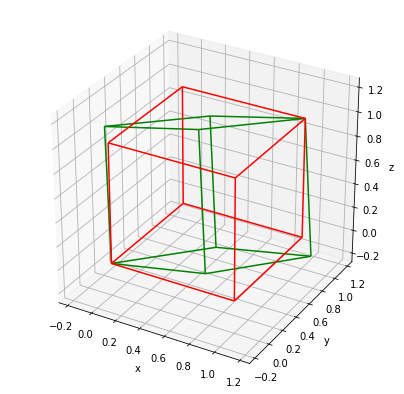

In [11]:
v, e = unit_cube
vr = r.apply(v)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
draw_wireframe(ax, (v,e))
draw_wireframe(ax, (vr,e), colors='green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

#### Assignment 3.1. (1pt)

To give our pinhole camera in the next section something more challenging to look at you have to define a house wireframe. Start with the cube and add two vertices at (0.5, 0, 1.5) and (0.5, 1, 1.5) and add the appropriate edges (5 edges extra) to make the shape of a house.

In [12]:
house = (np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                   [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1],
                   [0.5, 0, 1.5], [0.5, 1, 1.5]]),
             np.array([[0, 1], [1, 2], [2, 3], [3, 0],
                       [4, 5], [5, 6], [6, 7], [7, 4],
                       [0, 4], [1, 5], [2, 6], [3, 7],
                       [8, 4], [8, 5], [9, 6], [9, 7], [8,9]]))

In [13]:
try:
    assert len(house) == 2, "`house` should be a tuple of two arrays: one of vertices, one of edges."
except NameError as e:
    print("You need to define the variable `house`.")
    raise e
    
assert any(np.array_equal(np.array([0.5, 0., 1.5]), x) for x in house[0]), "At least one roof vertex is missing."
assert any(np.array_equal(np.array([0.5, 1., 1.5]), x) for x in house[0]), "One roof vertex is missing."
assert house[0].shape == (10, 3), "Do you have the right number of vertices in your house?"
assert house[1].shape == (17, 2), "Do you have the right number of edges in your house?"

# This is not good practice.
for i, row in enumerate(house[0]):
    if np.array_equal(np.array([0.5, 0., 1.5]), row):
        break

for j, row in enumerate(house[0]):
    if np.array_equal(np.array([0.5, 1., 1.5]), row):
        break

for row in house[1]:
    if np.array_equal(np.array([i,j]), row) or np.array_equal(np.array([j,i]), row):
        break
else:
    assert False, "There is no edge between the two roof vertices."

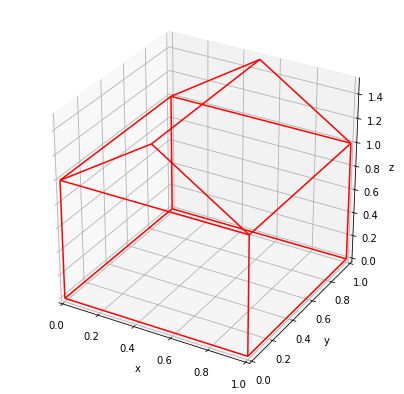

In [14]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
draw_wireframe(ax, house)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

And finally let's make it real Dutch: a row of 3 houses. Not three completely different houses but scaled and translated versions of our 'unit' house. You should position the three houses besides each other in x direction. The first house ``house1`` should start at (0,0,0) with depth (in the y direction) of 1 and height 1.5 (i.e. ``house1`` is ``house``). The second house should start at (1,0,0) but now with width 1.5 and height 2. The third house should be right next to house2 and have width 2 and height 1.2.

The catch is that you may not define new wireframes from scratch. You *have* to use transformations like scaling and translations to obtain the results.

#### Assignment 3.2 (4pt)

Implement the following three functions, which are used for scaling and translating wireframes, and applying arbitrary projective transformations.

In [15]:
# Complete all three functions below.
# You should use the transform_3d_wireframe function
# in the scale_3d_wireframe and translate_3d_wireframe functions

def transform_3d_wireframe(wf, A):
    return np.array([h2e(A @ e2h(p)) for p in wf[0]]), wf[1]

def scale_3d_wireframe(wf, sx, sy, sz):
    A = np.array([[sx, 0., 0., 0.],
                  [0, sy, 0., 0.],
                  [0., 0., sz, 0.],
                  [0., 0., 0., 1.]])
    return transform_3d_wireframe(wf, A)
    
def translate_3d_wireframe(wf, tx, ty, tz):
    A = np.array([[1., 0., 0., tx],
                  [0., 1., 0., ty],
                  [0., 0., 1., tz],
                  [0., 0., 0., 1.]])
    return transform_3d_wireframe(wf, A)
    

In [16]:
# Tests with a very simple wireframe.
test_wf = (np.array([[0, 0, 0], [1, 0, 0]]), np.array([[0, 1]]))

A = np.array([[1., 0., 0., 1.],
             [1., 1., 0., 0.],
             [0., 0., 1., 1.],
             [0., 0., 0., 1.]])

transformed_wf = transform_3d_wireframe(test_wf, A)
assert type(transformed_wf) == tuple and len(transformed_wf) == 2, "The output should again be a wireframe."
assert transformed_wf[0].shape == (2, 3) and transformed_wf[1].shape == (1, 2), \
    "The resulting wireframe should have the same shape."
assert np.array_equal(transformed_wf[1], test_wf[1]), "The incidence relations should be unchanged."
assert np.allclose(transformed_wf[0][0, :], np.array([1., 0., 1.]))

translated_wf = translate_3d_wireframe(test_wf, 1, 2, 3)
assert type(translated_wf) == tuple and len(translated_wf) == 2, "The output should again be a wireframe."
assert translated_wf[0].shape == (2, 3) and translated_wf[1].shape == (1, 2), \
    "The resulting wireframe should have the same shape."
assert np.array_equal(translated_wf[1], test_wf[1]), "The incidence relations should be unchanged."
assert np.allclose(translated_wf[0][0, :], np.array([1, 2, 3]))

scaled_wf = translate_3d_wireframe(translated_wf, 2, 3, 4)
assert type(scaled_wf) == tuple and len(scaled_wf) == 2, "The output should again be a wireframe."
assert scaled_wf[0].shape == (2, 3) and scaled_wf[1].shape == (1, 2), \
    "The resulting wireframe should have the same shape."
assert np.array_equal(translated_wf[1], scaled_wf[1]), "The incidence relations should be unchanged."
assert np.allclose(scaled_wf[0][1, :], np.array([4, 5, 7]))


#### Assignment 3.2 (2pt)

Use the functions you have defined above to define the variables `house1`, `house2`, `house3`, as described above.

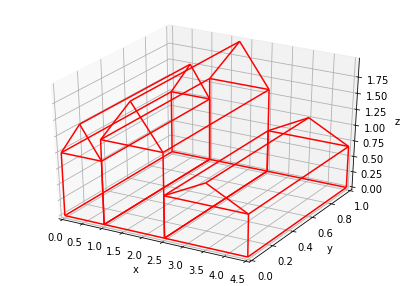

In [17]:
# define three variables house1, house2 and house3 using scaling and translation of house
# (where house1 is just equal to house). The resulting image should be a bird's eye view
# of three houses: the original, a taller and wider one, and a shorter and wider one.
house1 = house
house2 = translate_3d_wireframe(scale_3d_wireframe(house, 1.5, 1, 1.33), 1, 0, 0)
house3 = translate_3d_wireframe(scale_3d_wireframe(house, 2, 1, 0.67), 2.5 ,0 ,0)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
draw_wireframe(ax, house1)
draw_wireframe(ax, house2)
draw_wireframe(ax, house3);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


Nice, these 3D drawings, aren't they? But wait, 3D? On a 2D computer screen? That is what the pinhole camera is all about. How to project the 3D world onto a 2D screen (or retina, or camera plane). And that (or a simplification thereof) is what is done in the 3D drawing functions in Matplotlib.

In the next section you will experiment with the pinhole camera model as preparation for the final goal in this lab exercise, namely to estimate the pinhole camera model parameters from real images. So the final goal is different from what is done in computer graphics where the camera matrix is given (selected by the user or programmer).

## 4. The Pinhole Camera

In the lecture notes the pinhole camera was defined with the matrix $P$ mapping 3D coordinates onto a 2D plane:
\begin{align}
\hv x &\sim P\,\hv X
\end{align}
where $\hv x = (x\; y\; 1)\T$ is the homogeneous representation of a 2D point with coordinates $(x,y)$ and $\hv X = (X\; Y\; Z\; 1)\T$ is the homogeneous representation of the 3D point with coordinates $(X,Y,Z)$. Please note the use of $\sim$ where you might have expected $=$.

The camera matrix $P$ can be written as:
\begin{align}
    P = \underbrace{\begin{bmatrix}
    f_x & \gamma & u_0\\
    0 & f_y & v_0\\
    0 & 0 & 1
    \end{bmatrix}}_{P_{\mbox{internal}}}\,
    \underbrace{\begin{bmatrix}
    R\T & -R\T\v t
    \end{bmatrix}}_{P_{\mbox{external}}}
\end{align}

where $R$ is the rotation matrix and $\v t$ the translation that together determine the position of the camera in the 'real world'. Note that the last matrix (the external camera matrix) is in block form, its elementwise shape is $3\times4$.

In this section you have to construct both the internal matrix and external matrix according to geometrical specifications. Then you have to project a 3D wiremodel onto the 2D (retina) plane. 

Remember that a 3D point $\v X_c = (X_c\; Y_c\; Z_c)\T$  with coordinates given with respect to the *camera frame* is projected on the retina as:
\begin{align}
\hv x \sim \begin{bmatrix}
    f_x & \gamma & u_0\\
    0 & f_y & v_0\\
    0 & 0 & 1
    \end{bmatrix} \v X_c
    \end{align}
In the camera frame the $Z$ axis is pointing towards the scene (the optical axis). 

**Question.**

4.1. Explain why a camera matrix $P$ is semantically the same as (represents the same mapping as) the matrix $\alpha P$ for any scalar $\alpha\not=0$. (2pt)

\begin{align}
\hv x &\sim P\,\hv X
\end{align}
This means that x and Px are parallel, so the cross product of x and Px equals zero. Scaling one of the vectors doesn't change anything about its angle, meaning that no matter what value $\alpha$ is used to scale P, the resulting vector will still be parallel to the other one, meaning their cross product equaling zero still holds true, and therefore also \begin{align}
\hv x &\sim P\,\hv X
\end{align} does. 

To draw a camera in a scene it is customary in computer graphics and computer vision to draw the *frustum*: a small pyramid with a rectangular 'ground' plane (representing the size of the retina) and the top of the pyramid being the origin of the camera coordinate system. The pyramid indicates the field of view of the camera.

In the examples in these notes we will model a camera with a focal distance of 50 mm. Furthermore we assume the distances on the retina are measured in mm as well (in fact we will measure all distances for now in milimeters) and that the origin of the 2D coordinates on the retina are measured relative to an origin coinciding with the optical axis. Remember that the optical axis is the Z-axis in the camera coordinate system. Lastly we assume a skewless camera. This should be enough information for you to numerically define the internal camera matrix.

#### Assignment 4.2 (1pt)

Define the internal camera matrix, as described above.

In [18]:
# define the matrix (numpy array) P_intern, in accordance with the information above.
P_intern = np.array([[50, 0, 0],[0, 50, 0],[0, 0, 1]])

In [19]:
# There is a hidden test in this cell. Please do not delete it.

To draw the frustum we need to know where the camera is in the world coordinate system. That is why in the ``draw_frustum`` function we need both the internal and external camera matrices.

In [20]:
mnx = -18 # these are the sizes of the 35 mm film in classical camera's
mxx = +18 # still compatible with high end digital camera's
mny = -12
mxy = +12
P_intern = P_intern/P_intern[2,2]
fl = P_intern[0,0]
frustum = (np.array([[0,0,0], [mnx,mny,fl], [mxx,mny,fl], [mxx,mxy,fl], [mnx,mxy,fl]]),
           np.array([[0,1], [0,2], [0,3], [0,4],
                     [1,2], [2,3], [3,4], [4,1]]))
opt_axis = (np.array([[0, 0, 0], [0, 0, 5*fl]]),
            np.array([[0,1]]))

def draw_frustum(ax, P_intern, P_extern, optax=True, scale=1):
    F = inv(np.vstack((P_extern, np.array([[0,0,0,1]]))))
    sf = scale_3d_wireframe(frustum, scale, scale, scale)
    Fsf = transform_3d_wireframe(sf, F)
    draw_wireframe(ax, Fsf)    
    if optax:
        sax = scale_3d_wireframe(opt_axis, scale, scale, scale)
        Fsax = transform_3d_wireframe(sax, F)
        draw_wireframe(ax, Fsax, colors='g')

The code in the cell below should result in a picture like shown below: note the sizes of the 'retina'.
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/frustum_35mm.png"/>

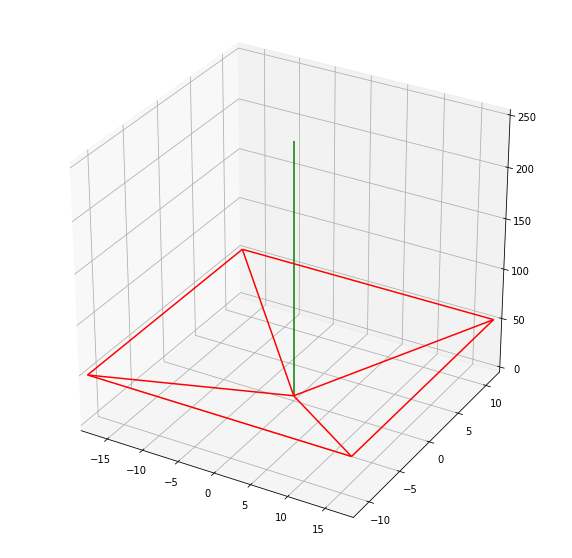

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

P_extern = np.column_stack((np.eye(3), np.zeros(3))) # 'identity'
draw_frustum(ax, P_intern, P_extern, scale=1)

#### Assignment 4.3 (4pt)

Now it is up to you to make a more realistic scene with the three houses and one camera. **All measurements are in millimeters.**

1. The camera is at location (0,0,1700) and pointing in the y direction and has focal length 50mm (and no translation internally and skew zero)

1. The front of the houses are at 20000 mm away from the camera (on the ground of course which is at z=0) and the unit house (``house1``) has a square base area of 4000 mm and a height of 6000 mm. The other houses scale up the same.

In the code below you are expected to 

- Define ``P_intern`` and ``P_extern``. Note that when rotating the
  3D world frame such that the z-axis is pointing towards the houses 
  (i.e. in the y direction of the world frame) you can't line up both the x and y axes of the camera frame up with
  the x and y axes of the world frame. You have to make a choice. 
  In the code below we expect you to align the y axes of both frames.
  We will then correct for the inversion of the x axis (that is the 
  consequence of this choice).

- Translate and scale the houses and thus define variables `house1mm`, `house2mm`
  and `house3mm` defining the wireframes of the houses at their 
  requested location and the requested sizes in millimeters.


The result of your code should be something like

<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/scene_cam.png" width="800" />

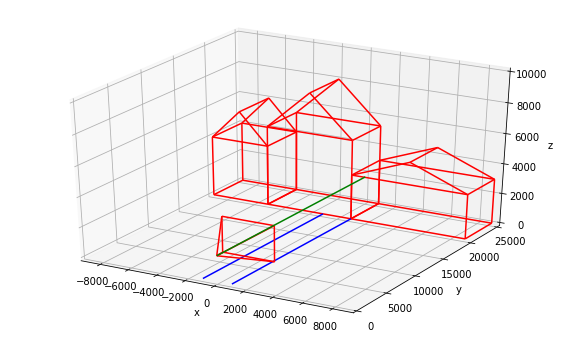

In [22]:
house1 = house
house2 = translate_3d_wireframe(scale_3d_wireframe(house, 1.5, 1, 1.33), 1, 0, 0)
house3 = translate_3d_wireframe(scale_3d_wireframe(house, 2, 1, 0.67), 2.5 ,0 ,0)

P_intern = np.array([[50, 0, 0], [0, 50, 0], [0, 0, 1]])

P_extern = np.array([[-1, 0, 0, 0], [0, 0, 1, -1700], [0, 1, 0, 0]])

house1mm = translate_3d_wireframe(scale_3d_wireframe(house, 4000, 5000, 4000), -9000, 20000, 0)
house2mm = translate_3d_wireframe(scale_3d_wireframe(house, 6000, 5000, 5320), -5000, 20000, 0)
house3mm = translate_3d_wireframe(scale_3d_wireframe(house, 8000, 5000, 3000), 1000, 20000 ,0)


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
draw_frustum(ax, P_intern, P_extern, scale=100) ## large scale needed to see the frustum
draw_wireframe(ax, house1mm)
draw_wireframe(ax, house2mm)
draw_wireframe(ax, house3mm)

lines_to_inf = (np.array([[-1000,0,0], [-1000,20000,0],
                          [1000, 0, 0], [1000, 20000, 0]]),
                np.array([[0,1], [2,3]]))
draw_wireframe(ax, lines_to_inf, colors='b')
ax.set_zlim(0, 10000);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Now we are in a position to see what the camera 'sees'. The result of the next cell should be something like
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/scene_view1.png" width="800" />

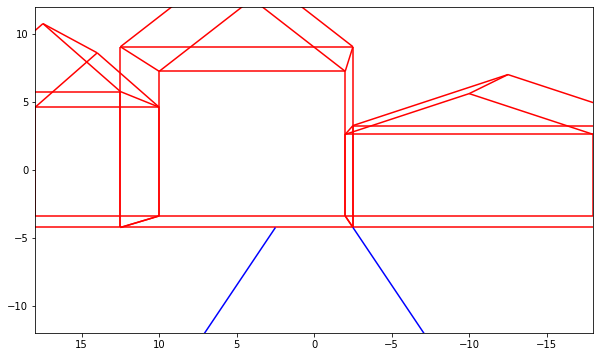

In [23]:
P = P_intern @ P_extern

house1p = transform_3d_wireframe(house1mm, P)
house2p = transform_3d_wireframe(house2mm, P)
house3p = transform_3d_wireframe(house3mm, P)

# note the y-coordinate of the lines start at 1 
# (instead of 0 in the previous 3D drawing)
lines_to_inf = (np.array([[-1000, 1,0], [-1000,20000,0],
                          [1000, 1, 0], [1000, 20000, 0]]),
                np.array([[0,1], [2,3]]))

linesp = transform_3d_wireframe(lines_to_inf, P)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
draw_wireframe(ax, house1p)
draw_wireframe(ax, house2p)
draw_wireframe(ax, house3p)

draw_wireframe(ax, linesp, colors='b', adapt=True) # this will enlarge the viewport... 

ax.set_xlim(-18, +18) # The standard format for 135 film ('kleinbeeldcamera')
ax.set_ylim(-12, +12) # idem
ax.invert_xaxis() # correction for the x-inversion


#### Questions (2pt each)

4.4. Where should the horizon be drawn in the picture above. Prove your point experimentally by setting the endpoints of ``lines_to_inf`` closer to infinity.

4.5. In the code where you did the camera projection yourself (just above) the starting y value of the 'lines to infinity' starts at 1 instead of 0. Why is that? You can try of course but we would like to read an explanation!

4.6. Compare the 2D drawing that Matplotlib made when you fed it with 3D wireframes with the drawing that you made of the 2D wireframes obtained by projecting the 3D wireframes on the retina of the camera. Explain why the 'Matplotlib camera' is called an affine camera and 'ours' is called a projective camera.

4.7. Can you think of a situation in which a real projective camera behaves more or less like an affine camera?

4.4 The line z = 0

4.5 Setting these values to zero reveals a 'divide by zero' error when running the code, and printing the results from the 3d transform function reveals a set of inf/-inf values that cause the lines not to be able to be drawn because their axis limits are invalid. This division problem is caused by the h2e function, which divides by the last element of the provided vector, in this case being zero. Setting the value to 1 solves the division error and allows the lines to be drawn.

4.6 Affine transformations don't change the origin and preserve paralellnes between lines, which
can also be seen in the Matplotlib drawings in the notebook. Our camera is capable of moving around
in a scene, and the according transformations necessary to still accurately represent an 'object' 
(such as one of the houses in this assignment) require more than an affine transform as perspectives
change more drastically, this can be seen in the drawings made by the projective camera as lines
that are originally parallel clearly aren't anymore after they've been projected (like the lines
to infinity above)

4.7 If its position in the world remains stationary while making images there is no need to change
the origin in a transformation and so a projective transform isn't necessary and affine transforms
will suffice to map say the images seen when the camera rotates along its own axes.

#### Assignment 4.8 (2pt)

In the code below, redefine `P_extern` to set the camera much further from the houses (i.e. at a negative y coordinate, say y=-10000). Leave the other parameters, like the viewport (x and y limits) the same, i.e. the way we have set the axes limits in the previous code block.

What happens? Add a comment with a brief description of what you see.

In [24]:
# Redefine the P_extern matrix to set the camera at larger distance from the houses
P_extern = np.array([[-1, 0, 0, 0], [0, 0, 1, -1700], [0, 1, 0, 10000]])

The result of the next cell should be something like:
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/scene_view2.png" width="800" />

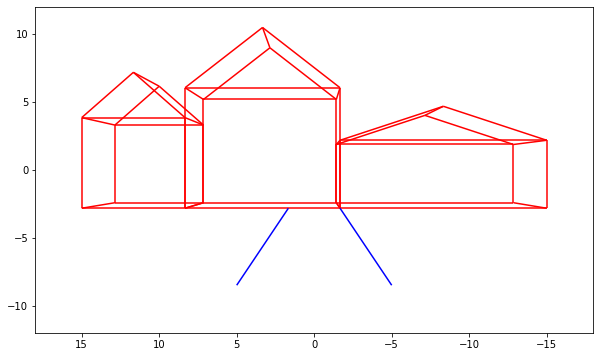

In [25]:
P = P_intern @ P_extern

house1p = transform_3d_wireframe(house1mm, P)
house2p = transform_3d_wireframe(house2mm, P)
house3p = transform_3d_wireframe(house3mm, P)

# note the y-coordinate of the lines start at 1 
# (instead of 0 in the previous 3D drawing)
lines_to_inf = (np.array([[-1000, 1,0], [-1000,20000,0],
                          [1000, 1, 0], [1000, 20000, 0]]),
                np.array([[0,1], [2,3]]))

linesp = transform_3d_wireframe(lines_to_inf, P)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
draw_wireframe(ax, house1p)
draw_wireframe(ax, house2p)
draw_wireframe(ax, house3p)

draw_wireframe(ax, linesp, colors='b') # this will enlarge the viewport... 

ax.set_xlim(-18, +18) # explicitly set the viewport of the 135 film camera
ax.set_ylim(-12, +12)
ax.invert_xaxis() # and correct for the x axis inversion

# Just as the question implies, changing the external matrix to account for a negative movement
# in the y-direction mimics the effects of distancing yourself from an object in order to see
# a smaller 'projection' of it, in this case allowing you to fully see the houses where previously
# only parts of them were visible.

## 5. Camera Calibration

The goal of camera calibration is to find the numerical relation
between the three dimensional points and the two dimensional points
where these are projected. Thus we have to find the camera matrix $P$
that projects points $(X,Y,Z)$ (in world coordinates) onto the 2D
points $(x,y)$ in the image:
\begin{align}
   \hv x \sim P \hv X
\end{align}

In the lecture notes it is demonstrated that, given the point correspondences $\hv x_i
\leftrightarrow \hv X_i$ for $i=1,\ldots,n$, we have to solve:
\begin{align}
   \begin{bmatrix}
   \hv X_1\T & \v 0\T & -x_1 \hv X_1\T \\
   \v 0\T & \hv X_1\T & -y_1 \hv X_1\T \\
   \vdots & \vdots & \vdots \\
   \hv X_n\T & \v 0\T & -x_n \hv X_n\T \\
   \v 0\T & \hv X_n\T & -y_n \hv X_n\T \\
   \end{bmatrix}
   \v p = \v 0 \\
   A \v p = \v 0
\end{align}

#### Questions (2pt each)

5.1. What is shape of the $A$ matrix? And what are the shapes of the $\v p$ vector and $\v 0$ vector?

5.2. Write down both the $A$ matrix as well as the $\v p$ vector in components (i.e. get rid of the block matrix notation).

5.1 A: (2n, 12), p: (12, 1), 0: (2n, 1)

5.2 \begin{align}
    A: 
   \begin{bmatrix}
   X_1& Y_1& Z_1& 1& 0& 0& 0& 0& -x_1*X_1 & -x_1*Y_1& -x_1*Z_1& -x_1 \\
   0& 0& 0& 0& X_1& Y_1& Z_1& 1& -y_1*X_1 & -y_1*Y_1& -y_1*Z_1& -y_1 \\
   \end{bmatrix}
\end{align}

p:
   \begin{matrix}
   P_1X& P_1Y& P_1Z& 1& P_2X& P_2Y& P_2Z& 1& P_3X & P_3Y & P_3Z & 1 \\
   \end{matrix}

#### Assignment 5.3 (4pt)

To find a null vector of $A$ we can use the same 'SVD trick' that we
have used to find the perspecive transform relating 2D points in one
image with 2D points in another image (now we are relating 3D points
with 2D points).

Given a null vector $\v p$ we can reshape it into the required camera
matrix $P$.

(The tests for this function will be a few cells later.)

In [26]:
def calibrate_pinhole_camera(xy, XYZ):
    """
    Use the SVD trick to find the transformation that most closely
    matches the transformation of the points given in XYZ (in 3D 
    Euclidean coordinates) to xy (in 2D Euclidean coordinates).
    """
    dim = len(XYZ)
    M = []
    for i in range(dim):
        M.append([XYZ[i][0], XYZ[i][1], XYZ[i][2], 1, 0, 0, 0, 0, -xy[i][0]*XYZ[i][0], 
                  -xy[i][0]*XYZ[i][1], -xy[i][0]*XYZ[i][2], -xy[i][0]])
        M.append([0, 0, 0, 0, XYZ[i][0], XYZ[i][1], XYZ[i][2], 1, -xy[i][1]*XYZ[i][0], 
                  -xy[i][1]*XYZ[i][1], -xy[i][1]*XYZ[i][2], -xy[i][1]])
    
    U, S, V_T = np.linalg.svd(M)
    P = V_T.T[:,-1]
    P = P.reshape(3,4)
    return P


To test your calibration function we will use the following image

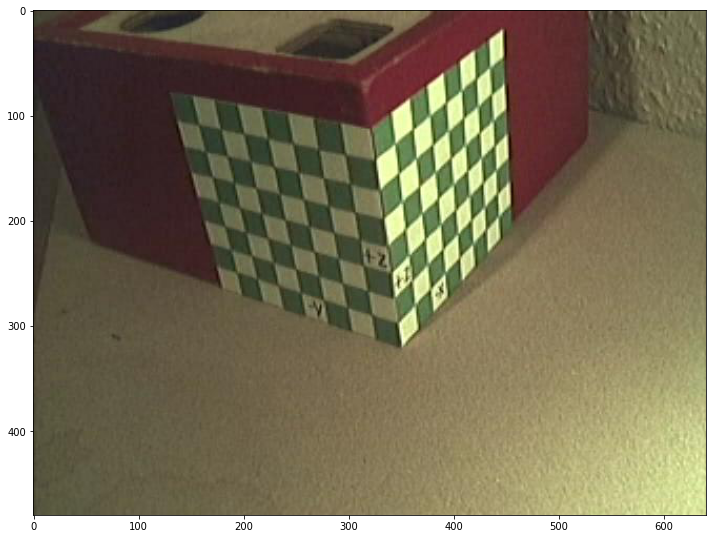

In [27]:
try:
    f = plt.imread('calibrationpoints.jpg')
except FileNotFoundError:
    wget.download('https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/calibrationpoints.jpg')
    f = plt.imread('calibrationpoints.jpg')
plt.figure(figsize=(10,10))
plt.imshow(f)
plt.tight_layout()

In this image we have marked 18 points in the image these are collected in the array ``xy``. The checker board patterns on the two perpendicular sides of the box depicted in the image allow us to pinpoint these 18 points in 3D coordinates as well (collected in the array ``XYZ``).

In [28]:
xy = np.array([[ 213.1027,  170.0499], [ 258.1908,  181.3219],
               [ 306.41  ,  193.8464], [ 351.498 ,  183.8268],
               [ 382.8092,  155.6468], [ 411.6155,  130.5978],
               [ 223.7485,  218.2691], [ 267.5841,  230.7935],
               [ 314.5509,  244.5705], [ 357.7603,  235.1771],
               [ 387.819 ,  205.1184], [ 415.3728,  178.1908],
               [ 234.3943,  263.9834], [ 276.9775,  277.1341],
               [ 323.318 ,  291.5372], [ 363.3963,  282.1438],
               [ 392.8288,  251.4589], [ 419.1301,  223.9051]])

XYZ = np.array([[0, -5, 5], [0, -3, 5], [0, -1, 5], [-1, 0, 5],
                [-3, 0, 5], [-5, 0, 5], [0, -5, 3], [0, -3, 3],
                [0, -1, 3], [-1, 0, 3], [-3, 0, 3], [-5, 0, 3],
                [0, -5, 1], [0, -3, 1], [0, -1, 1], [-1, 0, 1],
                [-3, 0, 1], [-5, 0, 1]])

Below we draw the image again and plot the 2D points from array ``xy`` on top of it.

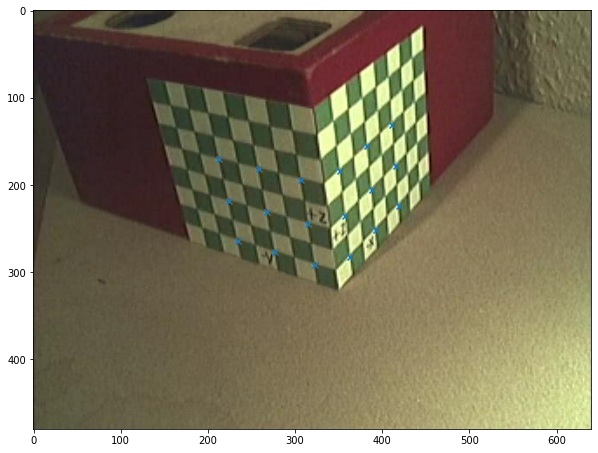

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(f)
plt.scatter(xy[:,0], xy[:,1], marker='x');

In [30]:
### Numerical test of calibration function
P = calibrate_pinhole_camera(xy, XYZ)
P = P/P[-1,-1]
assert np.allclose(P, np.array([
    [-2.53380724e+01,  1.76724681e+01, -9.75963068e+00, 3.50812662e+02],
    [ 8.94324977e+00,  1.92571438e+00, -2.83187164e+01, 3.22243837e+02],
    [-2.69423514e-02, -1.94940227e-02, -1.86848368e-02, 1.00000000e+00]]))


In case you pass the numerical test of your calibration function we can do a more insightfull test. We take the the 3D points in array ``XYZ`` and project each of the points (the rows) using the camera matrix $P$. Evidently we expect the projected points are close to the points in the ``xy`` matrix.

#### Assignment 5.4 (1pt)

Implement the following function, which applies a projection matrix P to an array of points (given in Euclidean coordinates).

In [31]:
def project_points(P, XYZ):
    return h2e(P @ e2h(XYZ.T)).T

In [32]:
assert np.allclose(
    project_points(np.column_stack((np.eye(3), np.array([1, 2, 3]))), np.array([[1, 0, 0], [0, 2, 3]])),
    np.array([[2/3, 2/3], [1/6, 2/3]]))


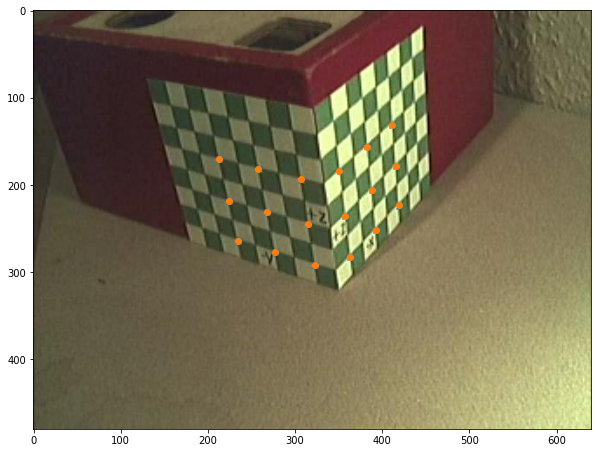

In [33]:
xy_p = project_points(P, XYZ)
plt.figure(figsize=(10,10))
plt.imshow(f)
plt.scatter(xy[:,0], xy[:,1], marker='x');
plt.scatter(xy_p[:,0], xy_p[:,1], marker='o');

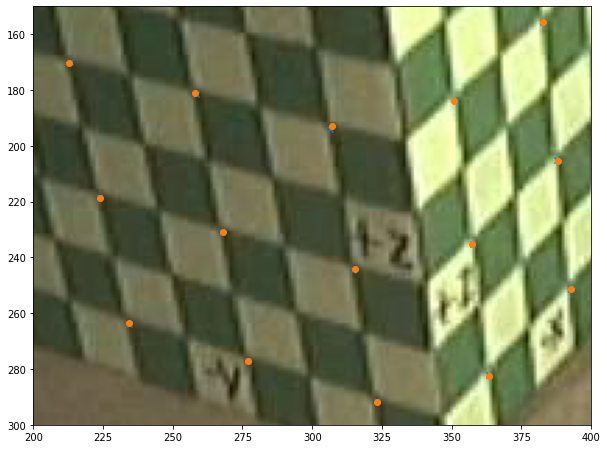

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(f)
plt.scatter(xy[:,0], xy[:,1], marker='x');
plt.scatter(xy_p[:,0], xy_p[:,1], marker='o');
plt.xlim(200, 400)
plt.ylim(300, 150); # note the 'strange' order: to keep the same orientation

In case you have done well the difference between the points in ``xy`` and ``xy_p`` are scarcely noticible. A quantative measure is the **reprojection error** as the average of the Euclidean distances between the points in ``xy`` and ``xy_p``.

#### Assignment 5.5 (1pt)

Write a function that computes the reprojection error given a vector `xy` and the result of the reprojection `xy_p`.

In [35]:
def reprojection_error(xy, xy_p):
    error = 0
    for i in range(len(xy)):
        error += np.sqrt((xy[i][0] - xy_p[i][0])**2 + (xy[i][1] - xy_p[i][1])**2)
    return error
print( reprojection_error(xy, xy_p))

7.590003972484747


In [36]:
### This cell contains a test, do not delete it.

## 6. Augmented Reality

The image that we have shown in the previous section depicts the real world. Now that we are able to calculate the camera matrix $P$ relating 3D coordinates to the image coordinates we can use computer graphic techniques to draw computer generated images of objects into the scene depicted in the image. In this exercise we keep things simple: the only objects we will draw are wireframe models. For more convincing and lifelike augmented reality we refer to a computer graphics course.

For instance take the unit cube and draw it in the scene (i.e. on top of the image) at the origin of the 3D coordinate frame. This should result in something like this:
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/drawcubeorigin.png" width="600" />

Two other positions that can be visually tested are given as well.

#### Assignment 6.1 (2pt)

Using your wireframe operations defined in section 3, as well as the `draw_wireframe` function, implement a function to draw a cube on top of an image.

In [37]:
def draw_cube(ax, P, X, Y, Z):
    unit_cube = (np.array([[0+X, 0+Y, 0+Z], [1+X, 0+Y, 0+Z], [1+X, 1+Y, 0+Z], [0+X, 1+Y, 0+Z],
                       [0+X, 0+Y, 1+Z], [1+X, 0+Y, 1+Z], [1+X, 1+Y, 1+Z], [0+X, 1+Y, 1+Z]]),
             np.array([[0, 1], [1, 2], [2, 3], [3, 0],
                       [4, 5], [5, 6], [6, 7], [7, 4],
                       [0, 4], [1, 5], [2, 6], [3, 7]]))
    projected = [project_points(P, unit_cube[0]), unit_cube[1]]
    draw_wireframe(ax, projected)
    

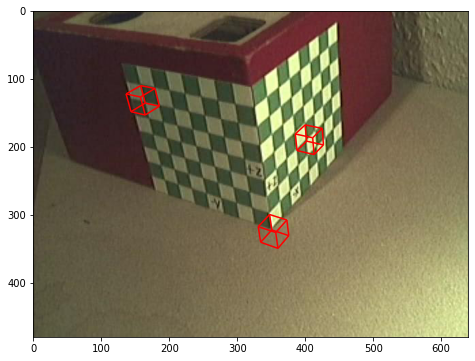

In [38]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.imshow(f)
draw_cube(ax, P, 0, 0, 0)
draw_cube(ax, P, 0, -7, 6)
draw_cube(ax, P, -4, 0, 3)

The traditional bonus for this lab exercise is to take the calibration and image done in the previous section and make an animation of a cube moving along a 3D circle $x^2+y^2=r^2$ and $z=0$ (i.e. as if it shifts over the table surface).

This year this is an extra challenge as it turns out to be impossible to hand in other files besides the one notebook file. The easiest way to do it is to make a video file where all the frames are calculated with the cube 'moving'. That is not an option this year.

I know it is possible to use Jupyter widgets to make an animation (i've seen it done). But you are on your own here! A nice simple elegant and portable solution wins eternal fame for the student making it into an animation template to be used by others (in coming years).

## 7. From 2D to 3D

The camera matrix $P$ maps 3D points in world coordinates onto 2D coordinates in camera coordinates. Be sure to understand that this mapping is **not invertible.** Does that mean that we cannot reconstruct the 3D world from (one or more) 2D images? O yes we can!

In general we need more than one image from the same scene taken from different viewpoints. A bit like the brain is able to reconstruct 3D space by looking with two eyes (To illustrate the need for two eyes, stretch you arms forwards in front of you but not extended completely, start with your hands far away from eachother. Point your index fingers of both hands towards eachother and **while having one eye closed** bring your hands together in a smooth movement and let the tops of two index fingers meet. Not many people succeed.) Looking with two eyes is called stereo vision and is an important subject in Computer Vision.

But even given only one image we can do some sort of 3D reconstruction. Instead of a second eye you could project a pattern on the objects in the scene and then you can reconstruct the 3D positions of the pattern points seen in the image. This is a very simplified view of how the Kinect camera works.

Even more simple solutions are practical in some situations. For instance if there is knowledge on which 3D plane a 2D point (x,y) lies you can reconstruct the 3D position (X,Y,Z) given the camera matrix $P$.

A plane in 3D space can be represented as:
\begin{align}
a X + b Y + c Z + d = 0
\end{align}
Using homogeneous coordinates we can write:
\begin{align}
\begin{bmatrix}a & b & c & d\end{bmatrix}\,
\begin{bmatrix}X \\ Y \\ Z\\ 1\end{bmatrix} = 0
\end{align}
or
\begin{align}
\hv N\T\, \hv X = 0
\end{align}

So the assumption is we know the plane $\hv p$, but we are also given a 2D point that is the projection $\hv x \sim P\,\hv X$ of a 3D point $\hv X$ on the plane $\hv N$. Summarizing we know:
\begin{align}
\hv N\T\, \hv X &= 0\\
\hv x &\sim P\,\hv X
\end{align}
where $\hv X$ is the only unknown.

In this section it is your task to give a matrix expression to find $\hv X$ given $\hv N$, $P$ and $\hv x$. 

#### Question 7.1 (2pt)

Mathematically derive how you can compute $\hv X$, using the information given above.

\begin{align}
\hv N\T\, \hv X &= 0\\
\hv x &\sim P\,\hv X
\end{align}

\begin{align}
\begin{bmatrix}\hv N\T\ \\ P \end{bmatrix} \hv X \sim
\begin{bmatrix} 0 \\ \hv x \end{bmatrix}
\end{align}

\begin{align}
 \hv X \sim
\begin{bmatrix}\hv N\T\ \\ P \end{bmatrix}^{-1}
\begin{bmatrix} 0 \\ \hv x \end{bmatrix}
\end{align}


#### Assignment 7.2 (1pt)

Next implement your solution (in case you need more than a few lines of code, your mathematical solution is possibly wrong; think again or ask for help).

In [40]:
def reconstruct(tN, P, tx):
    v = np.insert(tx, 0, 0)
    A = np.linalg.inv(np.vstack((tN, P)))
    return h2e(A @ v)

and test your solution on a few points in the ground plane for which the (X,Y,Z) coordinates are known:

In [44]:
XYZgp = np.array([[0,0,0],
                  [-2,0,0],
                  [-5,0,0],
                  [0,-2,0],
                  [0,-5,0]])
xygp = np.array([[352, 323],
                 [382, 290],
                 [423, 245],
                 [304, 307],
                 [239, 286]])
tN = np.array([0, 0, 1, 0])
P = np.array([[-2.53380724e+01,  1.76724681e+01, -9.75963068e+00, 3.50812662e+02],
    [ 8.94324977e+00,  1.92571438e+00, -2.83187164e+01, 3.22243837e+02],
    [-2.69423514e-02, -1.94940227e-02, -1.86848368e-02, 1.00000000e+00]])
XYZgprec = np.array([reconstruct(tN, P, e2h(xy)) for xy in xygp])
print(XYZgprec)

[[ 0.01560378  0.05847822  0.        ]
 [-1.95591727  0.07000317  0.        ]
 [-5.00858927  0.09106652  0.        ]
 [ 0.01950957 -1.96952444  0.        ]
 [ 0.0571054  -4.9586118   0.        ]]


If all went well you will see that XYZgp is about the same as XYZgprec. In that case the reconstruct function works as expected.

#### Question (2pt)

7.3. The method that you have implemented is NOT guaranteed to work. Not all planes in the 3D world lead to a possible reconstruction. Which planes will not lead to a solution?

The planes that would not lead to a solution are those that go through the exact 'location' of the camera and are parallel to the viewing axis (in the case of the camera from these exercises, y), because its projections (by applying the P matrix) could not be differentiated between, so a reconstruction couldn't be made.

Although this is a very simple 3D reconstruction technique it is very useful in practice. A few years ago a Master's student implemented a system for a commercial firm doing the lighting of big (pop) shows for his masters thesis. Below a performance of Rammstein. A camera high above the stage is looking down at the stage. The camera is calibrated and a geometrical model of the stage is available. When a performer is walking on the stage an operator tracks the feet of the performer. The system then knows on what surface he is and can reconstruct the 3D location of the performer and automatically point the spotlights at the performer. The system is really more complex than what we have done in this exercise but the basics are the same.

![Rammstein Stage](https://follow-me.nu/files/2019-10/19-07-16-mhvogel-4231-m1-web.jpg)
                                                   (photo: Manfred H. Vogel, 2019)